In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import matplotlib.cm as cm
from numba import jit
import sys
sys.path.append('../')
from util import angle_between
from segmentation import *
from plots import *

In [2]:
df = load_and_join('../../data/raw/trial10_fish0-anglefiltered.csv',
                  '../../data/raw/trial10_fish1-anglefiltered.csv')
df = add_velocity(clean_dataset(df))
df = interpolate_invalid(df)
df = smooth_dataset(df)

Index(['angle_f0', 'angle_f1', 'time', 'x_f0', 'x_f1', 'y_f0', 'y_f1',
       'dropped'],
      dtype='object')
[3.20397237 2.37840339 1.76780955 ... 3.3366143  3.34991316 2.953711  ]
Velocity has 0 #times: 0.0
[3.8732146  4.15246    7.48943745 ... 9.17475866 8.7924769  8.92359356]
Velocity has 0 #times: 0.0


../segmentation.py:101: RuntimeWarning: invalid value encountered in less
  print(f"Velocity has 0 #times: {(1.0 * (velocity < 0.0)).sum()}")


In [3]:
df.columns

Index(['angle_f0', 'angle_f1', 'dropped', 'speed_f0', 'speed_f1', 'time',
       'x_f0', 'x_f1', 'y_f0', 'y_f1', 'speed_smooth_f0', 'speed_smooth_f1',
       'acceleration_smooth_f0', 'acceleration_smooth_f1'],
      dtype='object')

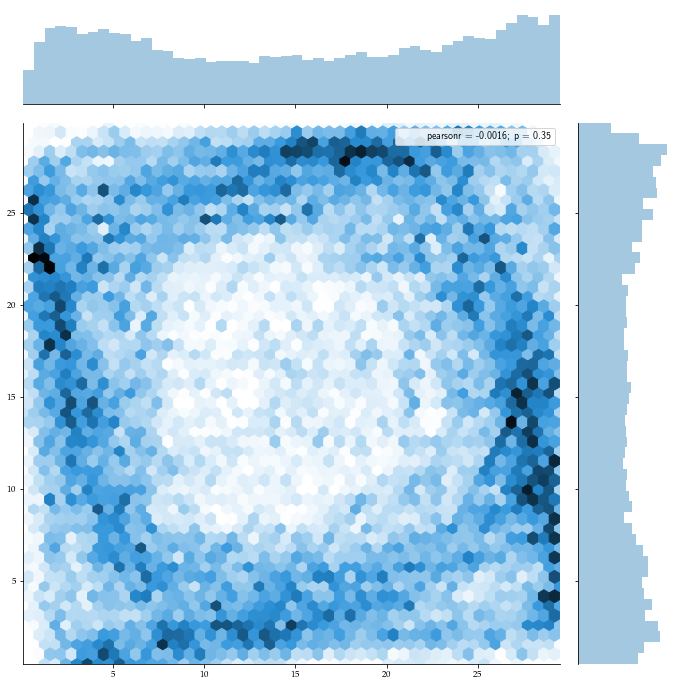

In [4]:
# Look at the density of the position.
x = df['x_f0'].values
y = df['y_f0'].values
fig = sns.jointplot(x,y, kind='hex')
fig.fig.set_figwidth(10)
fig.fig.set_figheight(10)

dict_keys(['paper', 'full', 'margin', 'beamer'])


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


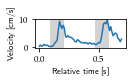

In [5]:
from scipy import signal
from segmentation import smooth_vector

print(col_widths.keys())
fig, ax = plt.subplots(1, figsize=get_figsize(columnwidth=col_widths['margin']))
offset = 2900
time = 70
velocity = df['speed_f0'].values
vel_smooth, vel_smooth_dt = smooth_vector(velocity) 
x = np.array([0.01 * i for i in range(time)])
y = velocity[offset:offset+time]
y_smooth = vel_smooth[offset:offset+time]
y_smooth_dt = vel_smooth_dt[offset:offset+time]
ax.plot(x, y)
is_acc = np.sign(y_smooth_dt) > 0

crossings = np.where(np.diff(np.signbit(y_smooth_dt)))[0] + 1
a = np.hstack(((crossings[1:][::2])))

b = np.hstack((crossings[:-1][::2]))

a, b = x[a], x[b]

ax.set_ylabel('Velocity [\si{\cm/\s}]')
ax.set_xlabel('Relative time [\si{\s}]')
fig.set_tight_layout(True)

for lo, hi in zip(a,b):
    ax.axvspan(xmin=lo, xmax=hi, color='lightgray', zorder=-1)
    
fig.savefig(f'../../figures/smoothing.pdf', transparent=True)

In [6]:
df_kicks_tr = pd.read_csv('../../data/processed/kicks_guy_train.csv')
df_kicks_te = pd.read_csv('../../data/processed/kicks_guy_test.csv')

df_kicks_tr = df_kicks_tr.loc[ df_kicks_tr['dt'] == 0, :]
df_kicks_te = df_kicks_te.loc[ df_kicks_te['dt'] == 0, :]
df_kicks = pd.concat((df_kicks_tr, df_kicks_te))
df_kicks = df_kicks.loc[ df_kicks['dt'] == 0, :]

0.3730369420180619
0.3730369420180619


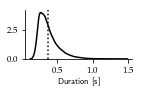

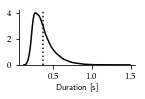

In [7]:
wf = {'margin': 1,
     'beamer': 0.5}
for target in ['margin', 'beamer']:
    fig, ax = plt.subplots(figsize=get_figsize(col_widths[target], wf=wf[target]))
    sns.kdeplot(df_kicks_tr['duration'], ax=ax, color='black', legend=False)
    ax.axvline(df_kicks_tr['duration'].mean(), linestyle='dotted', color='black')
    print(df_kicks_tr['duration'].mean())
    sns.despine(fig, ax)
    fig.tight_layout()
    ax.set_xlabel("Duration [\si{\s}]")
    fig.savefig(f'../../figures/kick_duration_{target}.pdf', transparent=True)

In [8]:
import dill as pickle
from sklearn.mixture import GaussianMixture
duration_mix = GaussianMixture(n_components=5)
duration_mix.fit(df_kicks_tr['duration'].reshape(-1,1))
duration_mix.score(df_kicks_te['duration'].reshape(-1,1))
with open('../../models/kick_duration.model', 'wb') as file:
    pickle.dump(duration_mix, file)

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


0.8257447413149183